# Titanic Survival Prediction: Final score of .77033

## 1.) Introduction

This project will try to predict the likelihood of survival for passengers on the Titanic.

### 1A.) Import Libraries

In [1]:
import sklearn  # Machine learning library
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Data visualization
import numpy as np  # Linear Algebra
import pandas as pd  # Pandas for data frames
import warnings
from sklearn.ensemble import StackingClassifier  # Final ensemble model
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.neighbors import KNeighborsClassifier  # KNearestNeighbors
from sklearn.ensemble import RandomForestClassifier  # Random Forests
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.model_selection import train_test_split, cross_val_score # Splitting training and validation data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve  # ROC curve plotting
from sklearn.feature_selection import RFECV # Recursive feature cross validation
from sklearn.metrics import classification_report  # Classification report matrix
from sklearn.preprocessing import power_transform  # Box cox transformation
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Future Warning in front of plots was annoying.
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")
sns.set_context(context=None, font_scale=1, rc=None)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24

## 2.) Loading Data

In [2]:
titanic = pd.read_csv('train.csv')  # Read in training dataset
test = pd.read_csv('test.csv')  # Read in testing dataset

### 2B.) Functions to make life easier

In [3]:
def make_probability_chart(dataframe, target, column):
    """Makes a bar chart showing survival rate by target variable"""
    f, ax = plt.subplots(figsize=(12, 8))
    dataframe.groupby([column])[target].mean().plot(kind='bar')
    plt.title(f'{target} by {column}')
    plt.ylabel(f"Probability of {target}")
    xvals = ax.get_xticks()
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in yvals])
    f.autofmt_xdate()
    plt.show()

def make_roc_auc_chart(model_name, y_true, y_pred):
    """Plots an ROC/AUC curve for a given model"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.show()

## 3.) Exploratory Data Analysis

### 3A.) First Glance

In [4]:
# First few rows
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Shape of dataset (rows, columns)
titanic.shape

(891, 12)

### 3B.) Survived

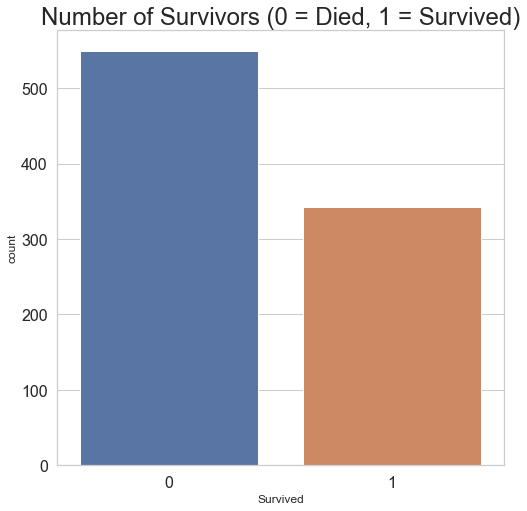

In [6]:
# Create a bar chart showing number of survivors.
f, ax = plt.subplots(figsize=(8, 8))
nsurvivors = sns.countplot(titanic['Survived']).set_title(
    'Number of Survivors (0 = Died, 1 = Survived)')
plt.show()

### 3C.) Passenger Class

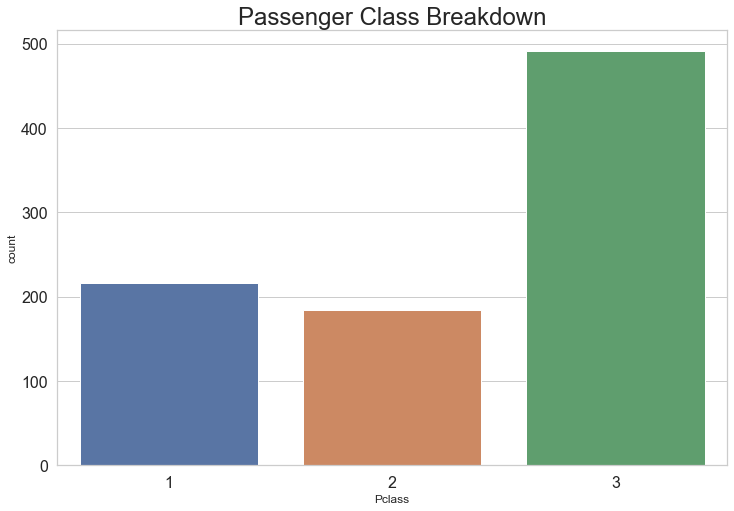

In [7]:
# Updating Color Palatte

plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Pclass']).set_title('Passenger Class Breakdown')
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


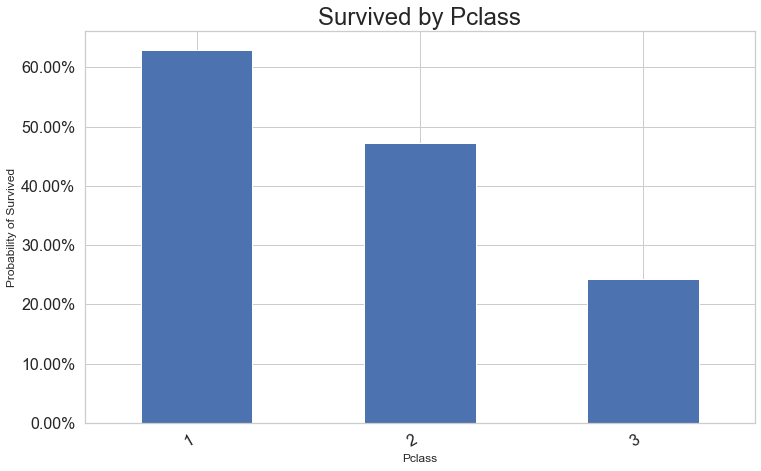

In [8]:
make_probability_chart(titanic, "Survived", "Pclass")

### 3D.) Name

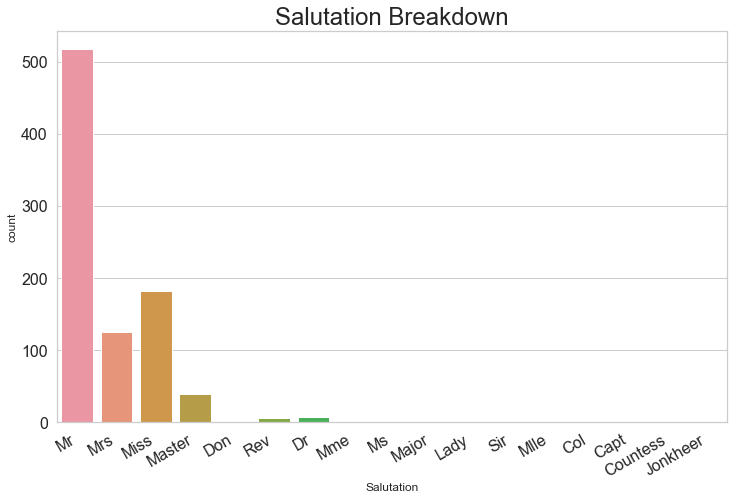

In [9]:
titanic['Salutation'] = titanic['Name'].str.extract('([A-Za-z]+)\.')
test['Salutation'] = test['Name'].str.extract('([A-Za-z]+)\.')

f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Salutation']).set_title('Salutation Breakdown')
f.autofmt_xdate()
plt.show()

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


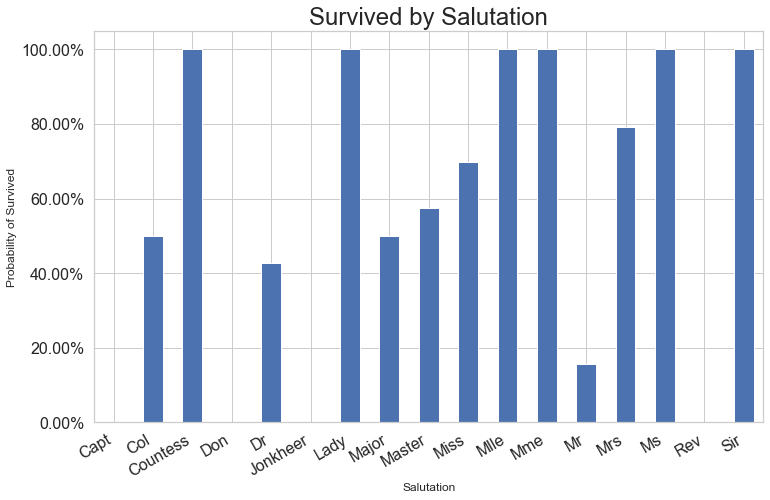

In [10]:
make_probability_chart(titanic, "Survived", "Salutation")

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


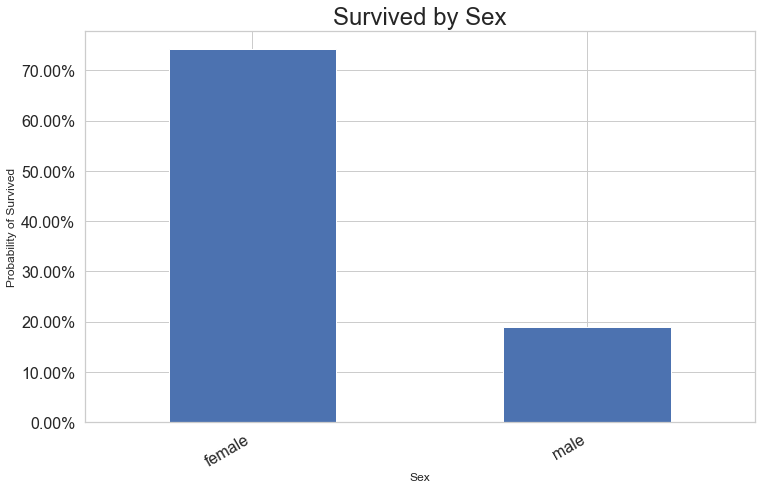

In [11]:
make_probability_chart(titanic, "Survived", "Sex")

### 3F.) Age

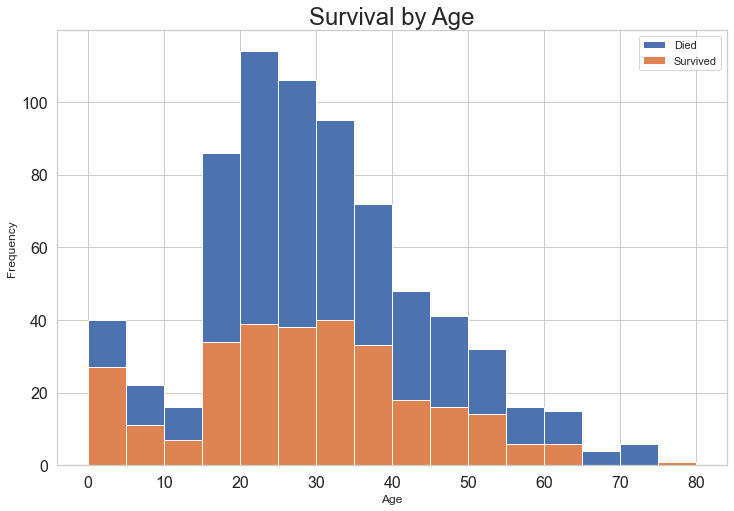

In [12]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Age'].plot.hist(bins=range(0, 85, 5))
age_plot = titanic[titanic['Survived'] ==
                   1]['Age'].plot.hist(bins=range(0, 85, 5))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Age')
age_plot.set_xlabel('Age')
plt.show()

### 3G.) Family

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


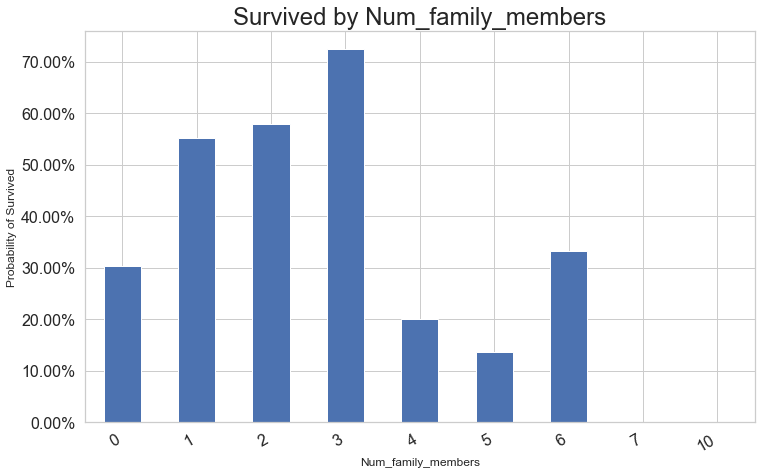

In [13]:
# Combining siblings and parents into family
titanic['Num_family_members'] = titanic['SibSp'] + titanic['Parch']
test['Num_family_members'] = test['SibSp'] + titanic['Parch']

titanic['large_family'] = titanic['Num_family_members'] >= 4
test['large_family'] = test['Num_family_members'] >= 4

make_probability_chart(titanic, "Survived", "Num_family_members")

### 3H.) Cabin

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


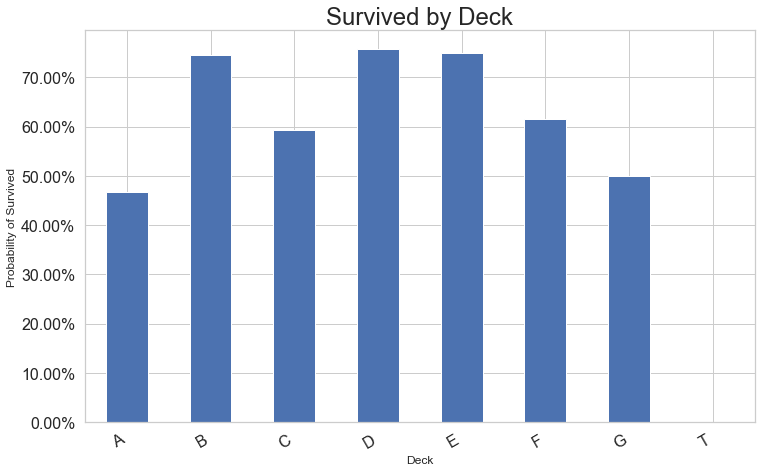

In [14]:
# Replaced cabins with a deck. NaNs for level have 'n'.
titanic['Deck'] = titanic['Cabin'].str[0]
test['Deck'] = test['Cabin'].str[0]

make_probability_chart(titanic, "Survived", "Deck")

### 3I.) Fare

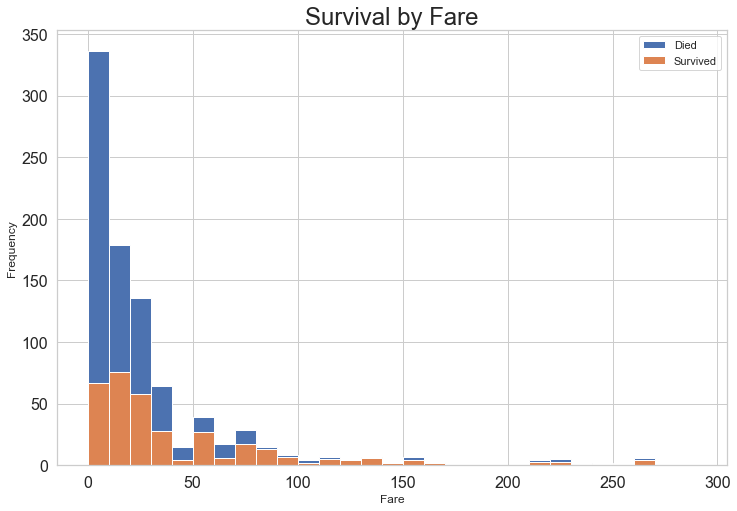

In [15]:
# Create a stacked histogram to show survival by age.
f, ax = plt.subplots(figsize=(12, 8))
titanic['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot = titanic[titanic['Survived'] ==
                   1]['Fare'].plot.hist(bins=range(0, 300, 10))
age_plot.legend(['Died', 'Survived'])
age_plot.set_title('Survival by Fare')
age_plot.set_xlabel('Fare')
plt.show()

### 3J.) Embarked

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


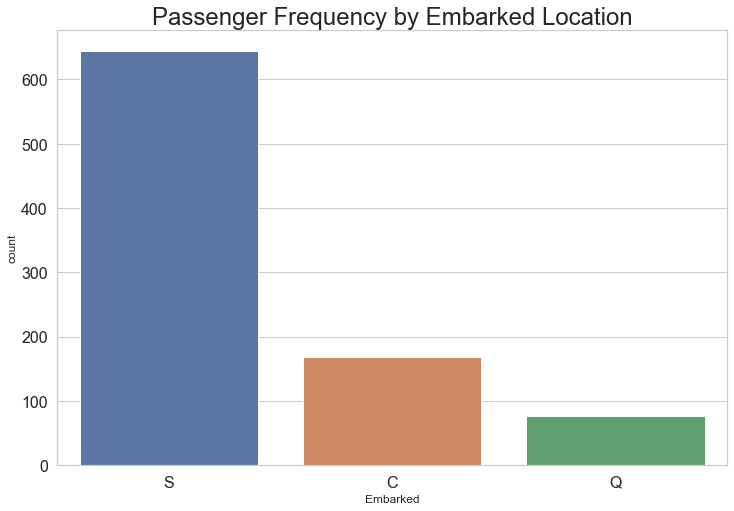

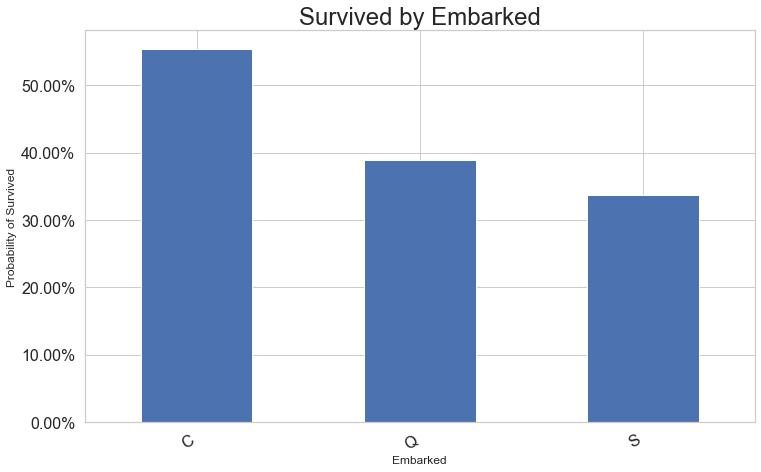

In [16]:
f, ax = plt.subplots(figsize=(12, 8))
sns.countplot(titanic['Embarked']).set_title(
    'Passenger Frequency by Embarked Location')
make_probability_chart(titanic, "Survived", "Embarked")

## 4.) Filling in Missing Values

### 4A.) Figure out what is missing

In [17]:
print("Training Data")
print(titanic.isnull().sum())
print('\n')
print("Testing Data")
print(test.isnull().sum())

Training Data
PassengerId             0
Survived                0
Pclass                  0
Name                    0
Sex                     0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
Salutation              0
Num_family_members      0
large_family            0
Deck                  687
dtype: int64


Testing Data
PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                    86
SibSp                   0
Parch                   0
Ticket                  0
Fare                    1
Cabin                 327
Embarked                0
Salutation              0
Num_family_members      0
large_family            0
Deck                  327
dtype: int64


### 4B.) Age

In [18]:
titanic['Age'].isnull().sum()

177

In [19]:
age_by_salutation = titanic.groupby('Salutation')['Age'].mean()

In [20]:
titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.mean()))
test['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(titanic['Age'].mean()))


titanic['Age_Bucket'] = pd.cut(titanic['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 90])
test['Age_Bucket'] = pd.cut(titanic['Age'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 90])

### 4C.) Deck

In [21]:
# Replaced cabins with a cabin level. NaNs for level have 'n'.
titanic['Deck'] = titanic['Deck'].fillna('N')
test['Deck'] = test['Deck'].fillna('N')

# There is no deck 'T' on the Titanic, so replacing that with 'N':
titanic[titanic['Deck'] == 'T'] = titanic[titanic['Deck'] == 'T'].replace('T', 'N')
test[test['Deck'] == 'T'] = test[test['Deck'] == 'T'].replace('T', 'N')

### 4D.) Fare

In [22]:
# Fill the one NA in test with the fare median
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

titanic['Fare'] = pd.qcut(titanic['Fare'], 10)
test['Fare'] = pd.qcut(test['Fare'], 10)

### 4E.) Embarked

In [23]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
# According to Encyclopedia Titanica, both of the null passengers embarked at Southampton.
# https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html
titanic['Embarked'].fillna('S', inplace=True)

### 4F.) Sanity Check

In [25]:
# Sanity check to make sure all missing values are taken care of. Cabin won't be in any of the models, so we're good.
titanic.isnull().sum()
test.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 327
Embarked                0
Salutation              0
Num_family_members      0
large_family            0
Deck                    0
Age_Bucket              0
dtype: int64

## 5.) Model Preparations

### 5A.) Engineer Features

In [26]:
titanic['Age'] = titanic.groupby("Salutation")["Age"].transform(lambda x: x.fillna(x.median()))
test['Age'] = test.groupby("Salutation")["Age"].transform(lambda x: x.fillna(titanic['Age'].median()))
test['Age'] = test['Age'].fillna(np.median(titanic['Age']))


### 5B.) Drop Columns

In [27]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         891 non-null    int64   
 1   Survived            891 non-null    int64   
 2   Pclass              891 non-null    int64   
 3   Name                891 non-null    object  
 4   Sex                 891 non-null    object  
 5   Age                 891 non-null    float64 
 6   SibSp               891 non-null    int64   
 7   Parch               891 non-null    int64   
 8   Ticket              891 non-null    object  
 9   Fare                891 non-null    category
 10  Cabin               204 non-null    object  
 11  Embarked            891 non-null    object  
 12  Salutation          891 non-null    object  
 13  Num_family_members  891 non-null    int64   
 14  large_family        891 non-null    bool    
 15  Deck                891 non-null    obje

In [28]:
top_four = titanic['Salutation'].value_counts().nlargest(4).index
titanic['Salutation'] = titanic['Salutation'].where(
    titanic['Salutation'].isin(top_four), other="Other")
test['Salutation'] = titanic['Salutation'].where(
    test['Salutation'].isin(top_four), other="Other")

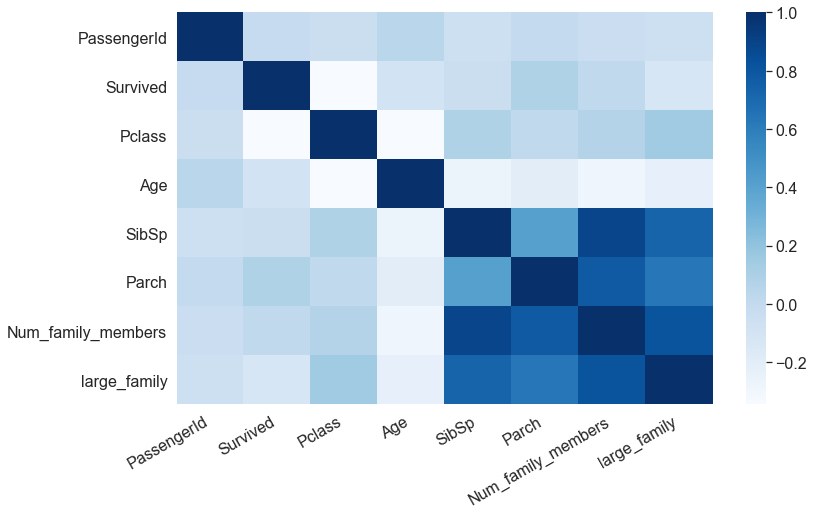

In [29]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(titanic.corr(), cmap='Blues')
f.autofmt_xdate()

In [30]:
# Dropping columns not needed in the model.
X_train = titanic.drop(['Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket', 'Salutation'], 1)  # 1 is to specify columns
y_train = titanic['Survived']
X_test = test.drop(['PassengerId', 'Cabin', 'Name', 'Ticket', 'Salutation'], 1)

In [31]:
X_train['Pclass'] = X_train['Pclass'].astype("category")
X_test['Pclass'] = X_train['Pclass'].astype("category")

### 5C.) Add Dummy Variables

In [32]:
# Fit and transform categorical variables to integers
X = pd.get_dummies(X_train, columns=['Sex', 'Embarked', 'Deck', 'Age_Bucket', 'Fare'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked', 'Deck', 'Age_Bucket', 'Fare'], drop_first=True)
column_names = list(X.columns)

In [33]:
y = titanic['Survived']
logreg_sm = sm.Logit(y.astype(float), X.astype(float)).fit()
print(logreg_sm.summary())

Optimization terminated successfully.
         Current function value: 0.418060
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      855
Method:                           MLE   Df Model:                           35
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.3722
Time:                        14:27:32   Log-Likelihood:                -372.49
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.418e-72
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Pclass                    -0.0029      0.221     -0.013      0.990      -0.437      

In [34]:
X['large_family'] = X['large_family'].map({False: 0, True: 1})
X_test['large_family'] = X_test['large_family'].map({False: 0, True: 1})

### 5D.) Check for Multicolinearity

In [35]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

C:\Users\Tom\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                   feature         VIF
0                   Pclass   35.037734
1                      Age  447.320659
2                    SibSp         inf
3                    Parch         inf
4       Num_family_members         inf
5             large_family    3.947111
6                 Sex_male    3.519894
7               Embarked_Q    2.079425
8               Embarked_S    5.917416
9                   Deck_B    3.194084
10                  Deck_C    3.830448
11                  Deck_D    2.442323
12                  Deck_E    2.465840
13                  Deck_F    1.734025
14                  Deck_G    1.297511
15                  Deck_N   41.800941
16      Age_Bucket_(5, 10]    1.805128
17     Age_Bucket_(10, 15]    2.592699
18     Age_Bucket_(15, 20]   15.173238
19     Age_Bucket_(20, 25]   37.345470
20     Age_Bucket_(25, 30]   38.633720
21     Age_Bucket_(30, 35]   98.624301
22     Age_Bucket_(35, 40]   53.066677
23     Age_Bucket_(40, 45]   40.453924
24     Age_Bucket_(45, 50

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_test.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_test.values, i) for i in range(len(X_test.columns))]

print(vif_data)

                  feature         VIF
0                  Pclass    9.671919
1                     Age  503.178258
2                   SibSp    4.735855
3                   Parch    1.596549
4      Num_family_members    6.077794
5            large_family    2.451163
6                Sex_male    3.127734
7              Embarked_Q    2.324930
8              Embarked_S    4.895072
9                  Deck_B    2.560314
10                 Deck_C    4.325555
11                 Deck_D    2.160069
12                 Deck_E    1.918868
13                 Deck_F    1.691979
14                 Deck_G    1.127925
15                 Deck_N   26.670322
16     Age_Bucket_(5, 10]    1.550342
17    Age_Bucket_(10, 15]    2.596357
18    Age_Bucket_(15, 20]   16.531357
19    Age_Bucket_(20, 25]   45.145672
20    Age_Bucket_(25, 30]   48.952855
21    Age_Bucket_(30, 35]   94.888797
22    Age_Bucket_(35, 40]   65.237573
23    Age_Bucket_(40, 45]   51.959414
24    Age_Bucket_(45, 50]   26.126834
25    Age_Bu

In [37]:
X = X.drop(['Age', 'Deck_N', 'Num_family_members'], 1)
X_test = X_test.drop(['Age', 'Deck_N', 'Num_family_members'], 1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(
    X.values, i) for i in range(len(X.columns))]

print(vif_data)

                   feature        VIF
0                   Pclass  17.766622
1                    SibSp   3.759962
2                    Parch   2.810750
3             large_family   3.908569
4                 Sex_male   3.492197
5               Embarked_Q   2.072213
6               Embarked_S   5.784866
7                   Deck_B   1.649507
8                   Deck_C   1.793674
9                   Deck_D   1.332064
10                  Deck_E   1.238442
11                  Deck_F   1.067945
12                  Deck_G   1.061152
13      Age_Bucket_(5, 10]   1.440684
14     Age_Bucket_(10, 15]   1.366691
15     Age_Bucket_(15, 20]   2.910562
16     Age_Bucket_(20, 25]   4.037638
17     Age_Bucket_(25, 30]   3.141651
18     Age_Bucket_(30, 35]   5.149337
19     Age_Bucket_(35, 40]   2.546148
20     Age_Bucket_(40, 45]   1.905473
21     Age_Bucket_(45, 50]   1.799651
22     Age_Bucket_(50, 55]   1.498787
23     Age_Bucket_(55, 60]   1.350123
24     Age_Bucket_(60, 90]   1.465049
25      Fare

In [38]:
assert len(X_test.columns) == len(X.columns)

### 5E.) Normalizing Features

In [39]:
X_train = StandardScaler().fit_transform(X)
X_test = StandardScaler().fit_transform(X_test)

### 5F.)  Split Titanic Data into Training and Validation Model

In [40]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, titanic['Survived'], test_size=0.3, random_state=42)

## 6.) Modeling and Verifying Model

### 6A.) Logistic Regression

In [41]:
logreg = LogisticRegression(max_iter=10000, penalty='l2')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_validation)
print(classification_report(y_validation, y_pred_log))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict(X_validation)
y_pred_proba = logreg.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       157
           1       0.81      0.75      0.78       111

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

Accuracy score: 0.8208955223880597


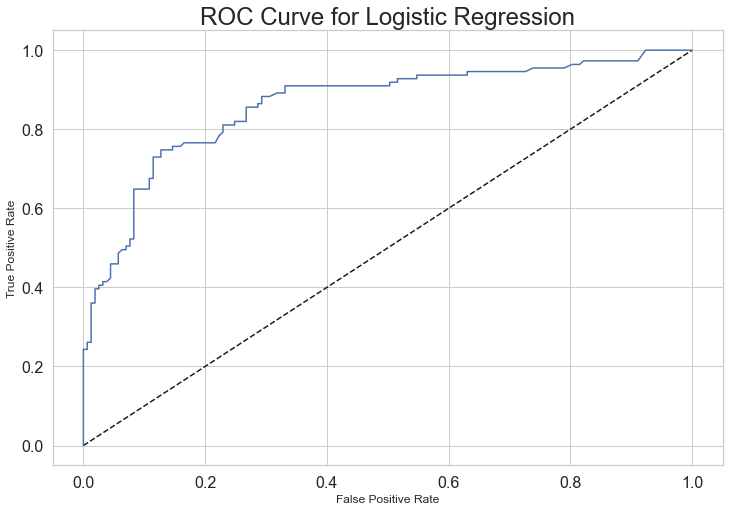

In [42]:
make_roc_auc_chart("Logistic Regression", y_validation, y_pred_proba)

Optimal number of features: 3
Optimal features:  ['large_family', 'Sex_male', 'Deck_E']


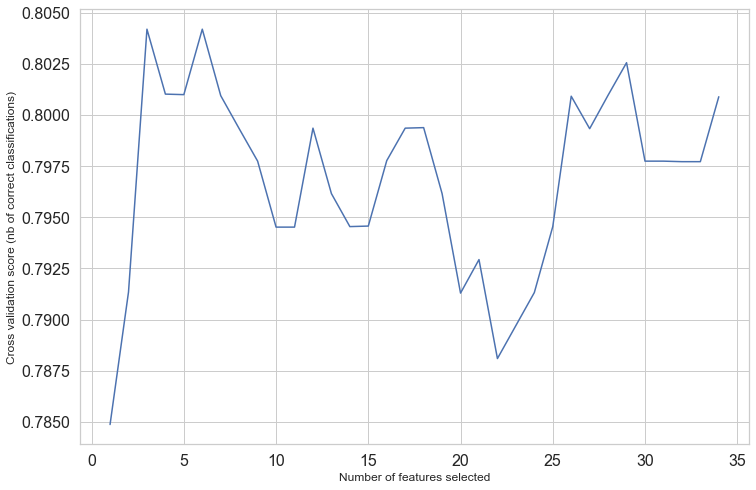

In [43]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(max_iter=10000),
              step=1, cv=10, scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features: %d" % rfecv.n_features_)
print("Optimal features: ", list(X.columns[rfecv.support_ == 1]))

plt.figure(figsize=(12, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Hyperparameter tuning: Logistic Regression

In [44]:
# Create the parameter grid
lr = LogisticRegression(max_iter=10000)
param_grid = {'C': [.001, .1, 1, 2, 5, 10, 100, 1000],
             'penalty': ['l1', 'l2']}

logreg_cv = GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=-1,
                                verbose=5, return_train_score=True, cv=5)
y_pred_gridsearch = logreg_cv.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred_gridsearch))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       157
           1       0.80      0.69      0.74       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

Accuracy score: 0.8022388059701493


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.5s finished


### 6B.) Random Forest

In [45]:
random_forest = RandomForestClassifier(n_estimators=1000, random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validation)
print(classification_report(y_validation, y_pred_rf))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = random_forest.predict(X_validation)
y_pred_proba = random_forest.predict_proba(X_validation)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)

print("Accuracy score:", accuracy_score(y_validation, y_pred_prob))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       157
           1       0.77      0.72      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.79      0.79      0.79       268

Accuracy score: 0.7947761194029851


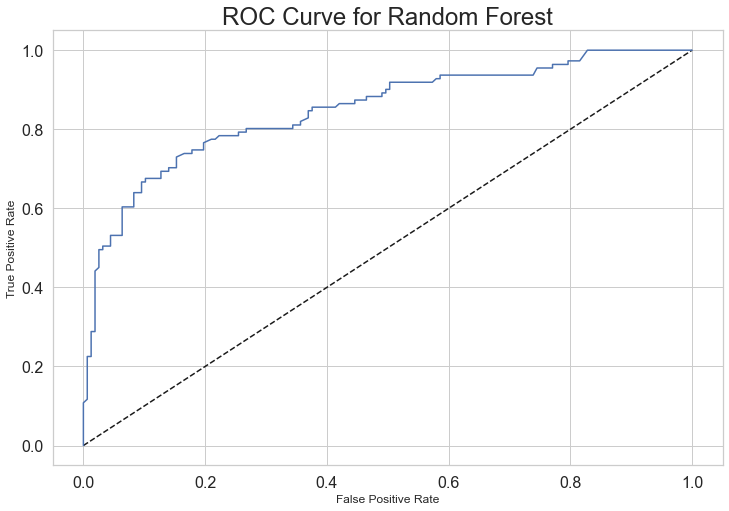

In [46]:
plt.figure(figsize=(12, 8))
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.show()

In [47]:
# Create the parameter grid
rf = RandomForestClassifier()
param_grid = {'n_estimators': [100],
              'max_depth': [x for x in range(3, 10)],
              'min_samples_leaf': [x for x in range(3, 20)],
              'max_features': ['sqrt', 'log2', .2]
              }

rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_jobs=-1,
                                verbose=5, return_train_score=True, cv=5, n_iter=100, random_state=42)

y_pred_gridsearch = rf_cv.fit(X_train, y_train).predict(X_validation)
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
print(classification_report(y_validation, y_pred_gridsearch))
print("Accuracy score:", accuracy_score(y_validation, y_pred_gridsearch))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   46.2s finished


              precision    recall  f1-score   support

           0       0.79      0.92      0.85       157
           1       0.85      0.65      0.73       111

    accuracy                           0.81       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.81      0.81      0.80       268

Accuracy score: 0.8059701492537313


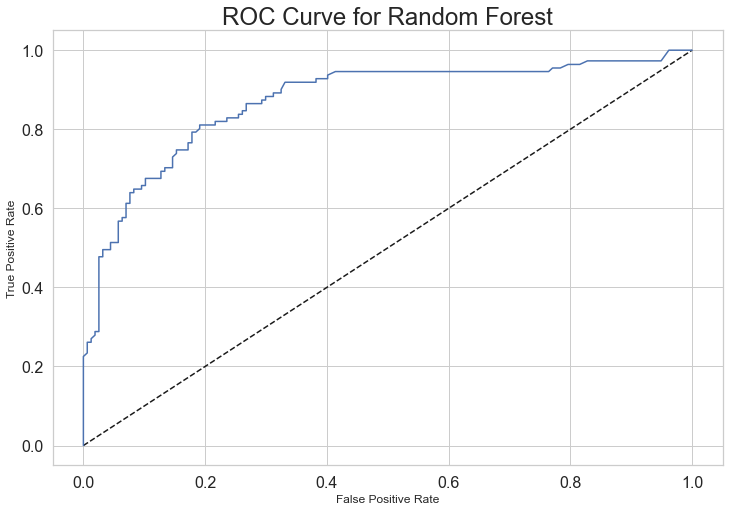

In [48]:
y_pred_proba = rf_cv.predict_proba(X_validation)[:, 1]
make_roc_auc_chart("Random Forest", y_validation, y_pred_proba)

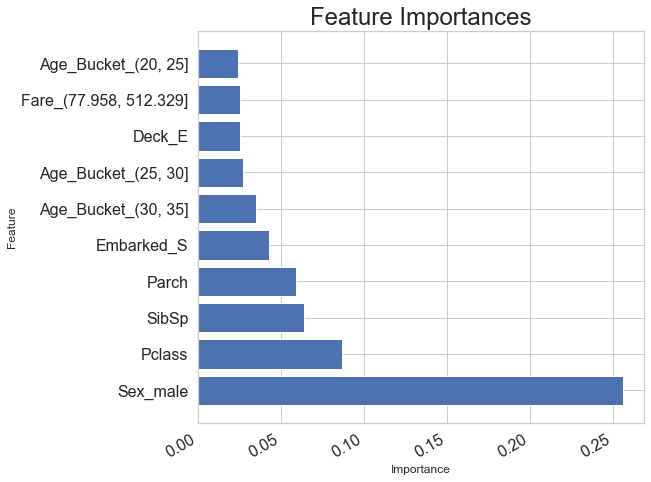

In [49]:
feature_importances = pd.DataFrame(zip(list(X.columns), random_forest.feature_importances_), columns=(
    "Feature", "Importance")).sort_values(by="Importance", ascending=False)[0:10]
f, ax = plt.subplots(figsize=(8, 8))
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
f.autofmt_xdate()
plt.show()

### 6C.) K-Nearest Neighbors 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       157
           1       0.76      0.69      0.73       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

Accuracy score: 0.7835820895522388


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished


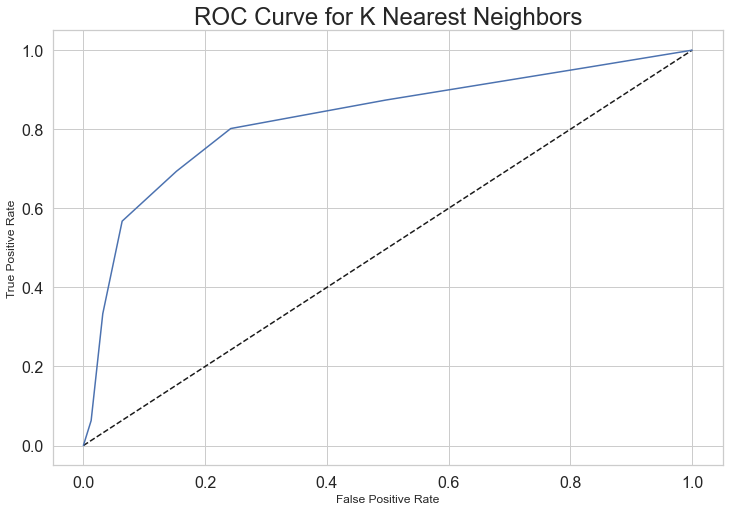

In [50]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]}
knn = sklearn.neighbors.KNeighborsClassifier()
knn_gridsearch = GridSearchCV(
    knn, param_grid=param_grid, n_jobs=-1, verbose=5, return_train_score=True, cv=5)
y_pred = knn_gridsearch.fit(X_train, y_train).predict(X_validation)
y_pred_proba = knn_gridsearch.predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds

fpr, tpr, thresholds = roc_curve(y_validation, y_pred_proba)
print(classification_report(y_validation, y_pred))
print("Accuracy score:", accuracy_score(y_validation, y_pred))
make_roc_auc_chart("K Nearest Neighbors", y_validation, y_pred_proba)

In [51]:
knn_gridsearch.best_params_

{'n_neighbors': 7}

### 6D.) Gradient Boosting Classifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.1min finished


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       157
           1       0.81      0.72      0.76       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

Accuracy score: 0.8134328358208955


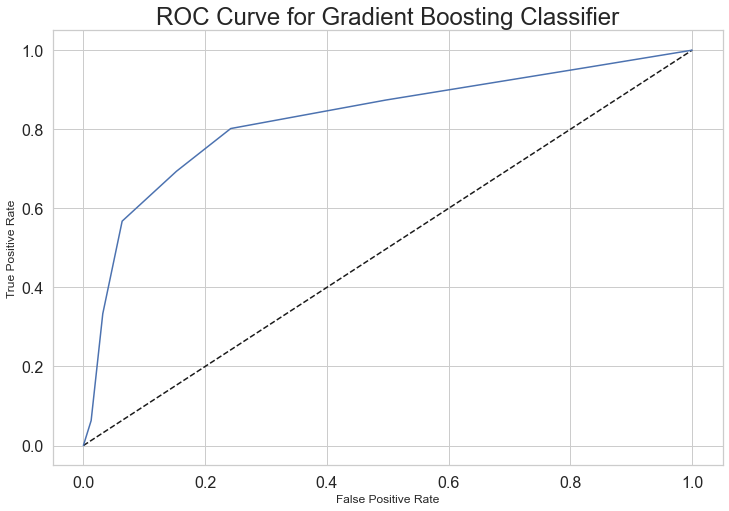

In [52]:
param_grid = {'learning_rate': np.linspace(.01, .3, 30),
              'max_depth': [x for x in range(2, 20)],
              'n_estimators': [100],
              'max_features': [.2, 'sqrt', 'log2'],
              'warm_start': [True]
              }
gbm = GradientBoostingClassifier()
gbm_random_search = RandomizedSearchCV(gbm,
                                       param_distributions=param_grid,
                                       scoring='balanced_accuracy',
                                       n_jobs=-1,
                                       verbose=5,
                                       n_iter=100,
                                       cv=5,
                                       return_train_score=True
                                       )

predictions = gbm_random_search.fit(X_train, y_train).predict(X_validation)
fpr, tpr, thresholds = roc_curve(y_validation, predictions)
print(classification_report(y_validation, predictions))
print("Accuracy score:", accuracy_score(y_validation, predictions))
make_roc_auc_chart("Gradient Boosting Classifier", y_validation, y_pred_proba)

In [53]:
print(logreg_cv.best_params_)
print(rf_cv.best_params_)
print(knn_gridsearch.best_params_)
print(gbm_random_search.best_params_)

{'C': 0.1, 'penalty': 'l2'}
{'n_estimators': 100, 'min_samples_leaf': 9, 'max_features': 0.2, 'max_depth': 9}
{'n_neighbors': 7}
{'warm_start': True, 'n_estimators': 100, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.07999999999999999}


## 7.) Conclusion

In [54]:
classifier1 = LogisticRegression(penalty='l2', C=logreg_cv.best_params_['C'], max_iter=10000)
classifier2 = RandomForestClassifier(max_depth=rf_cv.best_params_['max_depth'], min_samples_leaf=rf_cv.best_params_['min_samples_leaf'], max_features = rf_cv.best_params_['max_features'], n_estimators=2000, random_state=42)
classifier3 = KNeighborsClassifier(n_neighbors=knn_gridsearch.best_params_['n_neighbors'])
classifier4 = GradientBoostingClassifier(n_estimators=2000, max_features=gbm_random_search.best_params_['max_features'], max_depth=gbm_random_search.best_params_['max_depth'], learning_rate=gbm_random_search.best_params_['learning_rate'], random_state=42)
sclf = StackingClassifier(estimators=[('lr', classifier1), ('rf', classifier2), ('knn', classifier3), ('gbm', classifier4)]).fit(X, titanic['Survived'])
final_predictions = sclf.fit(X, y).predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       157
           1       0.80      0.70      0.75       111

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.81      0.80       268

Accuracy score: 0.8059701492537313


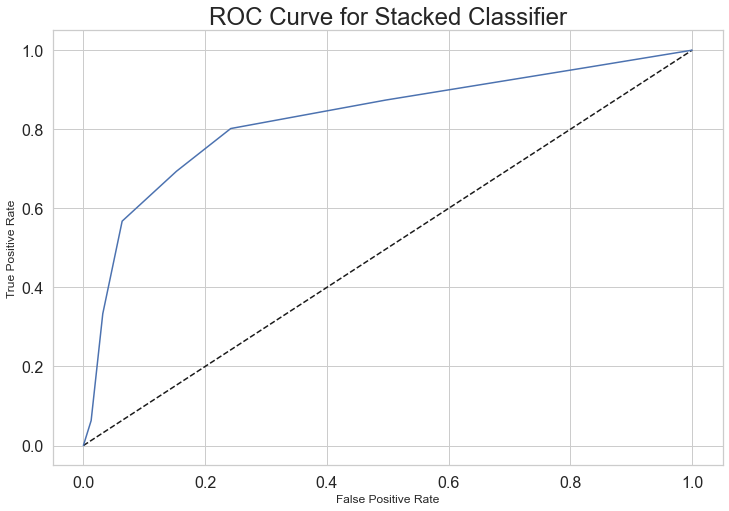

In [55]:
y_sclf = sclf.fit(X_train, y_train).predict(X_validation)
y_sclf_proba = sclf.fit(X_train, y_train).predict_proba(X_validation)[:, 1]
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_validation, y_sclf_proba)
print(classification_report(y_validation, y_sclf))
print("Accuracy score:", accuracy_score(y_validation, y_sclf))

make_roc_auc_chart("Stacked Classifier", y_validation, y_pred_proba)

In [56]:
pd.DataFrame(final_predictions, index=test['PassengerId'], columns=['Survived']).to_csv("Predictions.csv")

In [57]:
final_predictions.sum()

219

In [58]:
X_truncated = X[['large_family', 'Sex_male', 'Deck_E']]
X_test_df = pd.DataFrame(X_test, columns=list(X.columns))
X_test_truncated = X_test_df[['large_family', 'Sex_male', 'Deck_E']]

truncated_predictions = sclf.fit(X_truncated, y).predict(X_test_truncated)

In [59]:
pd.DataFrame(truncated_predictions, index=test['PassengerId'], columns=['Survived']).to_csv("Predictions.csv")
truncated_predictions.sum()

154